<a href="https://colab.research.google.com/github/danglies007/FreeWhisper/blob/main/Free_Whisper_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Whisper API

This notebook shows you how to create a **free, GPU-powered Speech-to-Text API** using **Whisper**.

For an explanation of how this works, see our companion article
[How to build a free GPU-powered Whisper API](https://www.assemblyai.com/blog/free-whisper-api-gpu/)

## Before you begin

Before you begin, make sure that this notebook has a GPU runtime:
1. Go to `Runtime > Change runtime type > GPU`
2. Select a GPU runtime, for example an A100 if it is available
3. Make sure to `Save` your changes


## Setup

First, install the Python packages we will need to run the application:

1. `Flask` - to build/serve our API
2. `pyngrok` - to serve our API over an Ngrok tunnel
3. `openai-whisper` - to run the Speech-to-Text inference

Run the cell below to install these packages

In [1]:
%%bash
pip install Flask pyngrok openai-whisper &> /dev/null

Next, make sure the notebook environment is running the latest version of ffmpeg. It should be pre-installed in the environment, but we will install it if it is not present and upgrade it if it is. Execute the below cell to do so:

In [ ]:
%%bash
sudo apt update &> /dev/null && sudo apt install --only-upgrade ffmpeg  &> /dev/null

Now, you'll need to specify your Ngrok API token. If you don't yet have an Ngrok accout, create one now:
1. Go to [Ngrok's signup form](https://dashboard.ngrok.com/signup) and create an account
2. Verify your email
3. Go to the ngrok dashboard and copy your Authtoken

If you already have an account, you can just go to your [dashboard](https://dashboard.ngrok.com/get-started/your-authtoken) and copy your Authtoken.

Paste your Authtoken below in place of `YOUR-AUTHTOKEN-HERE` and then execute the cell to set your Ngrok credentials in this notebook environment.

In [ ]:
!ngrok authtoken NGROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## Run Flask App

Now all you have to do is **run the below cell** to start up your free, GPU-powered Speech-to-Text API. When you do, you will see a URL in the cell output that ends in `.ngrok-free.app`

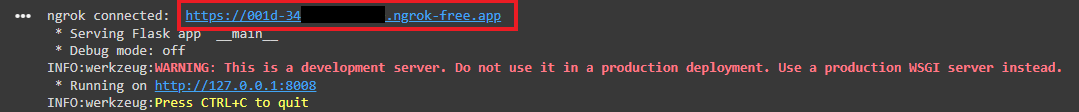

This is the base URL of your Speech-to-Text API. To transcribe a file, you can make a POST request to the `/transcribe` endpoint that contains a URL for an audio file in the JSON, along with the optional `model` parameter to specify which model you want to use. For example, here you can see this done in Python:

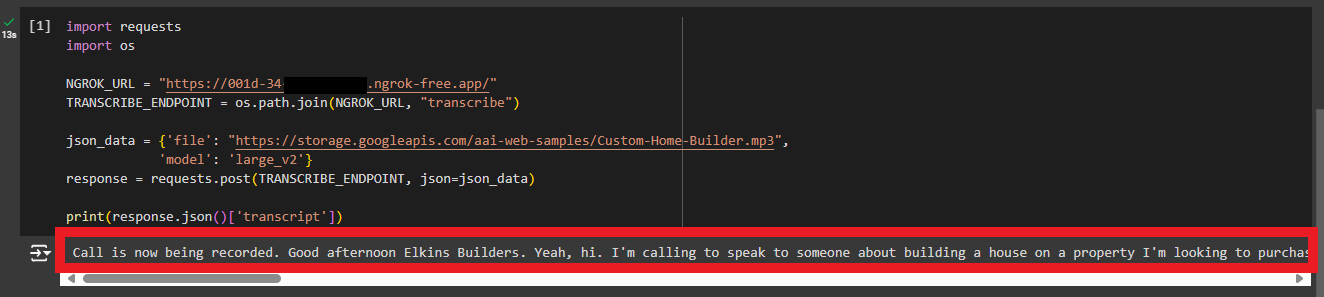

You can hit this API from any environment that supports POST requests. Here is how to do so with cURL:

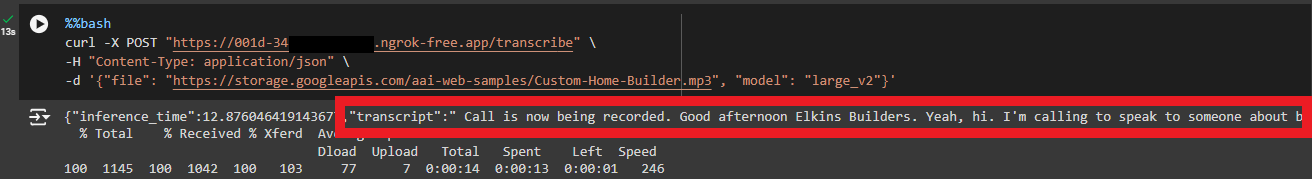

So, run the below cell to start your API, and then see the [next section](https://colab.research.google.com/drive/19cu4ev8ll4f60f4w69M2b3xkE50DMOK4#scrollTo=KbTEf-90LB2K&line=1&uniqifier=1) to copy the code examples used for the requests in the two screenshots above.

In [ ]:
from enum import Enum
import os
import time

from flask import Flask, request, jsonify
from pyngrok import ngrok
import requests
import whisper

# Define available Whisper model names
class ModelNames(str, Enum):
    tiny = 'tiny'
    tiny_en = 'tiny.en'
    base = 'base'
    base_en = 'base.en'
    small = 'small'
    small_en = 'small.en'
    medium = 'medium'
    medium_en = 'medium.en'
    large_v1 = 'large-v1'
    large_v2 = 'large-v2'
    large_v3 = 'large-v3'
    large = 'large'
    large_v3_turbo = 'large-v3-turbo'
    turbo = 'turbo'

# Store loaded Whisper models
WhisperModels = {k: None for k in ModelNames.__members__}

def load_model(model_name):
    """Function to load the Whisper model, caching it to avoid reloading."""
    try:
        # Access model value (string) from the enum
        if WhisperModels[model_name] is None:
            print(f"Loading model {model_name}")
            WhisperModels[model_name] = whisper.load_model(ModelNames[model_name].value)
        return WhisperModels[model_name], None, None

    except (RuntimeError, MemoryError) as e:
        # Catch memory-related errors and reset the loaded models
        print(f"Error loading model {model_name}: {e}")
        print("Clearing all models to free up memory.")

        # Clear all loaded models to free up memory
        WhisperModels.clear()
        WhisperModels.update({k: None for k in ModelNames.__members__})

        # Attempt to load the model again after clearing memory
        try:
            print(f"Retrying loading model {model_name}")
            WhisperModels[model_name] = whisper.load_model(ModelNames[model_name].value)
            return WhisperModels[model_name], None, None
        except (RuntimeError, MemoryError) as retry_error:
            # If it fails again, return a message indicating the memory issue
            print(f"Failed to load model {model_name} after memory reset: {retry_error}")
            # raise RuntimeError(f"Unable to load the model '{model_name}' due to insufficient memory.") from retry_error
            return None, jsonify({'error': f"Unable to load the model '{model_name}' due to insufficient memory."}), 500

def handle_file_upload(request):
    # Handle file in form-data (local file upload)
    if 'file' in request.files:
        file_input = request.files['file']
        if file_input.filename == '':
            return None, jsonify({'error': 'No file selected for uploading'}), 400
        file_path = os.path.join('temp_audio', file_input.filename)
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        file_input.save(file_path)
        return file_path, None, None

    # Handle JSON-encoded remote URL
    elif 'file' in request.json and isinstance(request.json['file'], str):
        file_input = request.json['file']
        if file_input.startswith('http') or file_input.startswith('https'):
            try:
                response = requests.get(file_input)
                response.raise_for_status()
            except requests.exceptions.RequestException as e:
                return None, jsonify({'error': f'Failed to download file: {e}'}), 400

            # Save the downloaded file to a temporary location
            file_path = os.path.join('temp_audio', 'remote_audio.mp3')
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            with open(file_path, 'wb') as f:
                f.write(response.content)
            return file_path, None, None
        else:
            return None, jsonify({'error': 'Invalid URL provided'}), 400
    else:
        return None, jsonify({'error': 'No valid file or URL provided'}), 400


# Initialize ngrok connection
if __name__ == "__main__":
    tunnel = ngrok.connect("8008")
    print("ngrok connected: ", tunnel.public_url)

    # Initialize Flask app
    app = Flask(__name__)

    @app.route('/transcribe', methods=['POST'])
    def transcribe():
        # Check if user passed in a model, or default to `tiny`
        if request.is_json and 'model' in request.json:
            model_name = request.json.get('model', 'tiny')
        else:
            model_name = request.form.get('model', 'tiny')

        # Validate that the model is a valid option
        if model_name not in ModelNames.__members__:
            return jsonify({'error': f'Invalid model name provided. Valid models are: {list(ModelNames.__members__.keys())}'}), 400

        # Load the specified or default model
        model, error_response, status_code = load_model(model_name)
        if error_response:
            return error_response, status_code

        # Handle file upload (local or remote) via helper function
        file_path, error_response, status_code = handle_file_upload(request)
        if error_response:
            return error_response, status_code

        # Transcribe the file using the selected model
        start_time = time.time()
        result = model.transcribe(file_path)
        inference_time = time.time() - start_time

        # Remove the temporary file
        os.remove(file_path)

        # Return the transcription
        return jsonify({
            'model_name': model_name,
            'transcript': result['text'],
            'inference_time': inference_time  # Include the timing data in the response
        })

    # Default route
    @app.route('/')
    def initial():
        return '<p>Hello from your Flask Whisper API!</p>'

    # Run the Flask app
    try:
      app.run(port=8008)
    finally:
      ngrok.kill()
      print('ngrok session terminated')

# Use your Speech-to-Text API

Copy the URL output by the cell above that ends in `.ngrok-free.app`

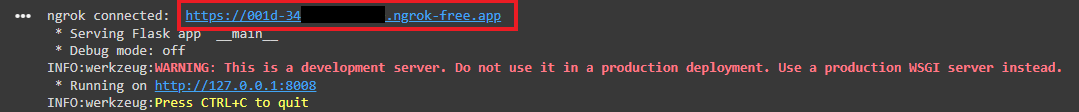

To hit this API with Python, replace `YOUR-NGROK-URL` with the URL you just copied. Then copy the below cell to another Colab notebook and execute it to use your API. You must do this in another notebook because the API is running in the previous cell, and you can't execute other cells in this notebook while it runs.

You can also execute the below cell locally on your system, but make sure to `pip install requests` before you do so.

In [ ]:
import requests
import os

NGROK_URL = "YOUR-NGROK-URL"
TRANSCRIBE_ENDPOINT = os.path.join(NGROK_URL, "transcribe")

json_data = {'file': "https://storage.googleapis.com/aai-web-samples/Custom-Home-Builder.mp3",
            'model': 'large_v2'}
response = requests.post(TRANSCRIBE_ENDPOINT, json=json_data)

print(response.json()['transcript'])

You can also use [cURL](https://man.archlinux.org/man/curl.1.en) to hit the API, which is available on both Windows and Unix systems. Again, copy the Ngrok URL from above and paste it in place of `YOUR-NGROK-URL` below. Then, copy the command from the cell below and execute it in a Command Prompt/Terminal on your local machine to hit your free Speech-to-Text API

In [ ]:
%%bash
curl -X POST "YOUR-NGROK-URL" \
-H "Content-Type: application/json" \
-d '{"file": "https://storage.googleapis.com/aai-web-samples/Custom-Home-Builder.mp3", "model": "large_v2"}'

You can replace the value for `model` in the request with any of the keys in the `ModelNames` Enum in the API Flask app cell. For example, you could also choose `large_v3` (*not* `large-v3`).

Additionally, while we only printed the `transcript` value from the JSON in the Python example above, you can also use the `inference_time` key to get the inference time for the submitted file on the specified model.

See our [companion article](https://www.assemblyai.com/blog/free-whisper-api-gpu/) for a comparison of inference times.